<a href="https://colab.research.google.com/github/MuhammedAshraf2020/Image-Captioning/blob/main/Image_Captioning_using_LSTM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collect Data

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:06<00:00, 161MB/s]
100% 1.04G/1.04G [00:07<00:00, 158MB/s]


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#!cp /content/flickr8k.zip /content/drive/MyDrive 

In [2]:
!cp /content/drive/MyDrive/flickr8k.zip /content

In [ ]:
!unzip /content/flickr8k.zip

# Data Visualize

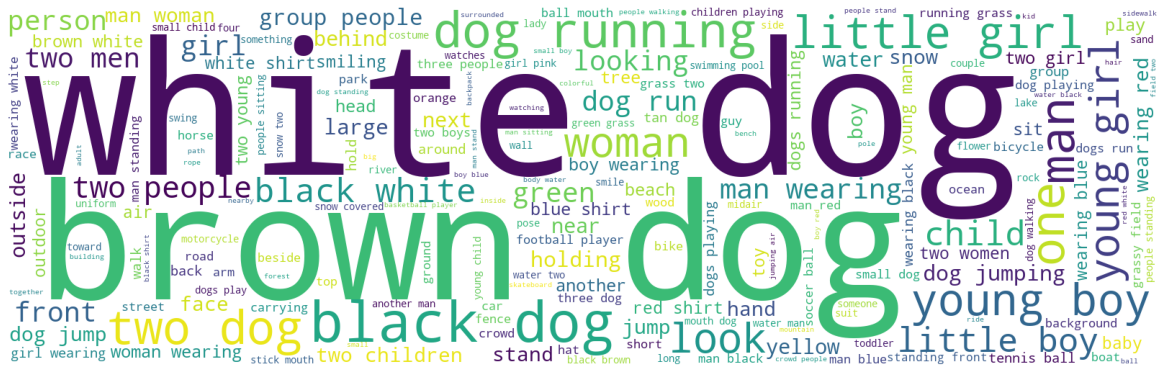

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv(r"/content/captions.txt", encoding ="latin-1")
 
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in df.caption:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1600, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [5]:
import cv2

def read_img(img_path):
  path = "/content/Images/" + img_path
  img  = cv2.imread(path)
  img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img  = cv2.resize(img , (400 , 400)) / 255.0
  return img

In [6]:
def sample(index):
  img_path = df.iloc[index][0]
  img = read_img(img_path)
  caption = df.iloc[index][1]
  return img , caption

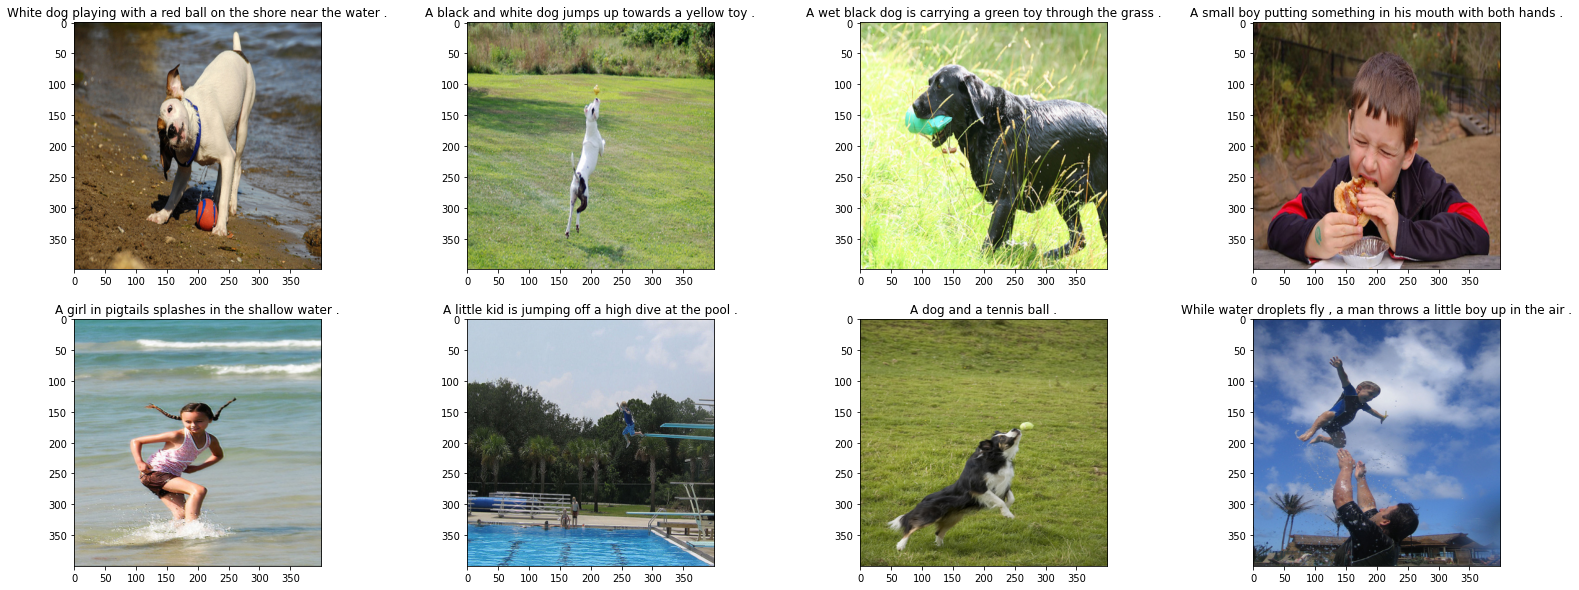

In [7]:
fig = plt.figure(figsize = (27 , 10))
rows = 2
cols = 4
for index in range(1 , rows * cols + 1):
  img , caption = sample(index * 38)
  fig.add_subplot(rows , cols , index)
  plt.imshow(img)
  plt.title(caption)

# DataLoader

In [8]:
import os
import torch
import pandas as pd
import PIL.Image as Image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [9]:
torch.backends.cudnn.benchmark = True

In [145]:
class Vocabulary:
  def __init__(self , path):
    self.dataset = pd.read_csv(path)
    self.tokenizer = Tokenizer()
    self.tokenizer.fit_on_texts(["eos" , "sos"])
    self.tokenizer.fit_on_texts(self.dataset["caption"].tolist())

In [146]:
vocabs = Vocabulary("/content/captions.txt")

In [147]:
transs = transforms.Compose([
                            transforms.ToTensor() ,
                            transforms.Resize((224 , 224)) ,
                            transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5)) ,
                             
])

In [148]:
class Dataset:
  def __init__(self , file_path , tokenizer , max_lens , imgs_paths , Transformers = None):
    
    self.Transformers = Transformers
    self.imgs_paths = imgs_paths
    self.max_lens  = max_lens
    self.tokenizer = tokenizer

    self.data = pd.read_csv(file_path)
    self.data["caption"] = self.data["caption"].apply(lambda x : add_tags(x))
    sequences = self.data["caption"].tolist()
    sequences = self.tokenizer.texts_to_sequences(sequences)
    self.sequences = pad_sequences(sequences , maxlen = max_lens , padding = "post" )

  def __len__(self):
    return len(self.data)

  def img_read(self , index):
    im_path   = self.data.iloc[index][0]
    full_path = os.path.join(self.imgs_paths , im_path) 
    img = Image.open(full_path).convert("RGB")
    if self.Transformers is not None:
      img = self.Transformers(img)
    return img  
  
  def __getitem__(self , index):
    img    = self.img_read(index)
    sentence = self.sequences[index]
    return img , torch.Tensor(sentence)


In [149]:
def add_tags(string):
  return "sos " + string + " eos"

In [168]:
train_data = Dataset(file_path = "/content/captions.txt"  , tokenizer = vocabs.tokenizer , 
                        max_lens = 15 ,imgs_paths = "/content/Images" , Transformers = transs)

train_loader = DataLoader(train_data , batch_size = 64 , shuffle = True)

# Build Model

## 1) Build Encoder Model

In [169]:
"""    for name, param in self.cnn.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
      else:
        param.requires_grad = False"""

'    for name, param in self.cnn.named_parameters():\n      if "fc.weight" in name or "fc.bias" in name:\n        param.requires_grad = True\n      else:\n        param.requires_grad = False'

In [170]:

import torchvision.models as models
import torch.nn as nn
import torch


class Encoder(nn.Module):
  def __init__(self , emb_size):
    super(Encoder , self).__init__()
    
    self.cnn = models.densenet121(pretrained = True)
    for param in self.cnn.parameters():
      param.requires_grad = False
    self.cnn.classifier   = nn.Linear(1024 , emb_size)

    self.dropout = nn.Dropout(0.6)
    #self.embedding = nn.Linear(1024 , emb_size)
    self.prelu = nn.PReLU()
  
  def forward(self , x ):
    x = self.prelu(self.cnn(x))
    x = self.dropout(x)
    return x

In [171]:
import torch

In [172]:
#test encoder
img1 = torch.randn(6 , 3 , 224 , 224).to("cuda")
encode = Encoder(50).to("cuda")
encode(img1).shape

torch.Size([6, 50])

### 2) Build Decoder Model

In [173]:
class Decoder(nn.Module):
  def __init__(self , emb_size , vocab_lens , hidden_size ,max_len = 15 ,  device = "cuda"):
    super(Decoder , self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.vocab_lens  = vocab_lens 
    self.emb_size    = emb_size
    self.max_len     = max_len
    
    self.embed = nn.Embedding(vocab_lens , embedding_dim = emb_size)
    self.lstm  = nn.LSTMCell(emb_size , hidden_size)
    self.out   = nn.Linear(hidden_size , vocab_lens)
    self.soft  = nn.Softmax(dim = 1)
  
  def forward(self , features , captions):
    batch_size = features.size(0)
    
    hidden , states = self.initial(batch_size)
    
    outputs = torch.empty((batch_size , captions.size(1) , self.vocab_lens)).to(self.device)
    
    caption_embed = self.embed(captions)
    
    for time_step in range(captions.size(1)):
      
      if time_step == 0:
        hidden , states = self.lstm(features , (hidden , states))
      
      else:
        hidden , states = self.lstm(caption_embed[: , time_step -1 , :] , (hidden , states))
      
      out = self.out(hidden)
      outputs[: , time_step , :] = out
    
    return outputs
  
  def initial(self , batch_size):
    h0 = torch.zeros(batch_size , self.hidden_size).to(self.device)
    c0 = torch.zeros(batch_size , self.hidden_size).to(self.device)
    return h0 , c0

In [174]:
#test decoder
feat   = torch.randn(6  , 50).to("cuda")
cap    = torch.randint(400 , (6 , 150)).to("cuda")
decode = Decoder(50 , 400 , 128 , "cuda").to("cuda")
torch.argmax(decode(feat , cap) , dim = 2).shape

torch.Size([6, 150])

# 3) Encoder-Decoder Model

In [175]:
class CapModel(nn.Module):
  def __init__(self , emb_size , vocab_lens , hidden_size , device = "cpu"):
    super(CapModel , self).__init__()

    self.encoder = Encoder(emb_size).to(device)
    self.decoder = Decoder(emb_size , vocab_lens , hidden_size , device).to(device)
  
  def forward(self , img , caption):
    features = self.encoder(img)
    output   = self.decoder(features , caption)
    return output
  
  def caption(self , img):
    with torch.no_grad():
      x = model.encoder(img)
      caption = []
      hidden , cell_state = self.decoder.initial(x.shape[0])
      
      for word in range(self.decoder.max_len):
        #input of time step to lstm
        hidden , cell_state = self.decoder.lstm(x , (hidden , cell_state))
        #get the word with heighest prop
        current_word = torch.argmax(self.decoder.soft(self.decoder.out(hidden)))
        #prepare word to be the next input ot lstm
        x = self.decoder.embed(current_word.unsqueeze(0))
        caption.append(current_word.item())
      
      return img , caption


# Setup Training Enviroment

In [176]:
import torch.optim as optim
from tqdm.notebook import tqdm

In [177]:
# hyperparameter
emb_size    = 50
vocab_lens  = len(train_data.tokenizer.word_index) + 1
hidden_size = 128 
device      = "cuda" if torch.cuda.is_available() else "cpu"
max_lens    = 10

In [178]:
print("Number of words  which we have : " , vocab_lens)

Number of words  which we have :  8496


In [179]:
model = CapModel(emb_size , vocab_lens , hidden_size , device).to(device)

In [180]:
opt  = optim.Adam(model.parameters())
critic = torch.nn.CrossEntropyLoss(ignore_index = 0)

In [183]:
def train(loader , model2 , loss , opt , vocab_lens , max_lens , device = "cpu"):
  model2.train()
  total_loss = []
  
  for index , (img , cap) in enumerate(loader):
    img = img.to("cuda")
    cap = cap.to("cuda").to(torch.int64)
    
    captions_train  = cap
    captions_target = cap
    predictions = model2(img , captions_train).float()


    if index % 500 == 0:
      cap1 = [i.item() for i in cap[0]]
      print("Original :" , train_data.tokenizer.sequences_to_texts([cap1[:]]))

      cap3 = [i.item() for i in captions_train[0]]
      print("Train    :" , train_data.tokenizer.sequences_to_texts([cap3[:]]))

      cap2 = [i.item() for i in captions_target[0]]
      print("Target   :" , train_data.tokenizer.sequences_to_texts([cap2[:]]))

      cap4 = [i.item() for i in torch.argmax(predictions[0] , 1)]
      print("Predict  :" , train_data.tokenizer.sequences_to_texts([cap4[:]])) 
      print("="*20)

    batch_loss  = loss(predictions.view(-1, vocab_lens) , captions_target.contiguous().view(-1))
    
    model.zero_grad()
    batch_loss.backward()
    opt.step()
    
    total_loss.append(batch_loss)
  
  return sum(total_loss) / len(total_loss)

In [185]:
for epoch in range(20):
  epoch_loss = train(train_loader , model , critic , opt , vocab_lens , max_lens)
  print(epoch_loss)

Original : ['sos a person is being swept to the ground by waves eos']
Train    : ['sos a person is being swept to the ground by waves eos']
Target   : ['sos a person is being swept to the ground by waves eos']
Predict  : ['african spectating submerges squeezed fences stirred massive grid fence aerobatics laugh graveyard spectating schoolyard schoolyard']
Original : ['sos a child who is celebrating their graduation in a field eos']
Train    : ['sos a child who is celebrating their graduation in a field eos']
Target   : ['sos a child who is celebrating their graduation in a field eos']
Predict  : ['sos a man is a running in on eos the field eos eos eos eos']
tensor(4.5923, device='cuda:0', grad_fn=<DivBackward0>)
Original : ['sos two children with hula hoops eos']
Train    : ['sos two children with hula hoops eos']
Target   : ['sos two children with hula hoops eos']
Predict  : ['sos a dogs are a are in a eos eos eos eos eos eos eos']
Original : ['sos man in action over a wave eos']
Train

In [195]:
def show_example(model , loader , eos):
  
  model.eval()
  with torch.no_grad():
    imgs , caps = next(iter(loader))
    x = imgs.to("cuda")[10].unsqueeze(0)
    img = x[0]
    x = model.encoder(x)
    #print(x.shape)
    #caps = caps.to("cuda").to(torch.int64)
    caption = []
    hidden , cell_state = model.decoder.initial(x.shape[0])
    for word in range(15):
      hidden , cell_state = model.decoder.lstm(x , (hidden , cell_state))

      current_word = torch.argmax(model.decoder.out(hidden))
     # print(current_word)
      
      x = model.decoder.embed(current_word.unsqueeze(0))
      caption.append(current_word.item())
      if current_word == eos:
        break
    
    return img , caption


In [194]:
eos = train_data.tokenizer.word_index["eos"]

In [226]:
img , cap = show_example(model , train_loader , eos)

In [227]:
train_data.tokenizer.sequences_to_texts([cap])

['sos a dog is running through a grassy field eos']

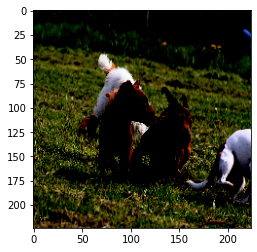

In [228]:
plt.imshow(img.cpu().permute(1 , 2 , 0) )
plt.show()